<a href="https://www.kaggle.com/code/ameau01/histopathologeic-cancer-detection?scriptVersionId=248071643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CSCA-5642: Kaggle Cancerous Cell Detection Project #
#### Develop an algorithm that identifies metastatic cancer in small image patches from digital pathology scans. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5642-week3/tree/main](https://github.com/alme9155/csca-5642-week3/tree/main)  


## I. Brief description of the problem and data ##

This project aims to tackle Kaggle's Cancer Detection challenge to identify cancerous cell images from non-cancerous using Convolutional Neural Network (CNN). The challenge is to create an algorithm to identify metastatic cancer in small image patches taken from larget digital pathlogy scans. The data of this Kaggle competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. 
### Dataset: ####
* The training dataset contains about 220,025 image patches already labeled 1 as cancerous, 0 as non-cancerous in "train_labels.csv".
* A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.
* Tumor tissue in the outer region of the patch does not influence the label. 

### Data Size and Dimension ####
* Training dataset: 220,025 tiff images
* Test dataset: 57,458 tiff images (~26% of training size)
* Each image patch is 96x96 pixel of RGB color images in tiff formats.
* Label CSV contains 2 columns: id, label (1 as cancerous, 0 as non-cancerous)

### Competition Rules ###
* Expected submission CSV files in the same format as "train_labels.csv" with two columns "id, label". (id: unique id from test set, label: 0, or 1)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
tif_files = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"\nos path: [{dirname}]")
    tif_file_count =0
    for filename in filenames:
        if filename.endswith('.tif'):
            tif_file_count +=1
            if tif_file_count < 3:
                print(os.path.join(dirname, filename))
            elif tif_file_count == 3:
                print("...")
        else:
            print(os.path.join(dirname, filename))  
    if tif_file_count > 0:
        print(f"\nTotal number of .tif files in {dirname}: {tif_file_count}")
        tif_file_count =0

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


os path: [/kaggle/input]

os path: [/kaggle/input/histopathologic-cancer-detection]
/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv

os path: [/kaggle/input/histopathologic-cancer-detection/test]
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
...

Total number of .tif files in /kaggle/input/histopathologic-cancer-detection/test: 57458

os path: [/kaggle/input/histopathologic-cancer-detection/train]
/kaggle/input/histopathologic-cancer-detection/train/d43c081bafa286f9c1f7e921883f26ceafebc912.tif
/kaggle/input/histopathologic-cancer-detection/train/092d0eedebce504847715ee046b6ad74b57599b4.tif
...

Total number of .tif files in /kaggle/input/histopathologic-cancer-detection/train: 220025


## II. Exploratory Data Analysis (EDA) ##
File: "train_label.csv"
- Inspect file columns, duplciates and null labels.
- Pre-process data frame to add 'train_filepath' for ease access to locate the files
- Pre-process data to convert 'label' as string
- Drop any rows in the dataset where corresponding .tif file path is missing.

In [3]:
import pandas as pd
import os 

train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print("shape:",train_labels.shape)
print("-- Label head ---")
print("################")
print(train_labels.head())
print("-----------------")
print("Missing values: ")
print("################")
print(train_labels.isnull().sum())
print("-----------------")
print(f"Sum of duplicated labels: {train_labels.duplicated().sum()}.")

shape: (220025, 2)
-- Label head ---
################
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
-----------------
Missing values: 
################
id       0
label    0
dtype: int64
-----------------
Sum of duplicated labels: 0.


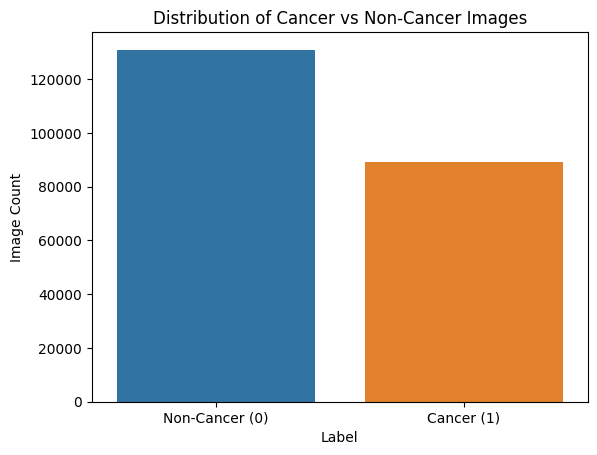

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_labels)
plt.xticks([0, 1], ['Non-Cancer (0)', 'Cancer (1)'])
plt.title("Distribution of Cancer vs Non-Cancer Images")
plt.ylabel("Image Count")
plt.xlabel("Label")
plt.show()

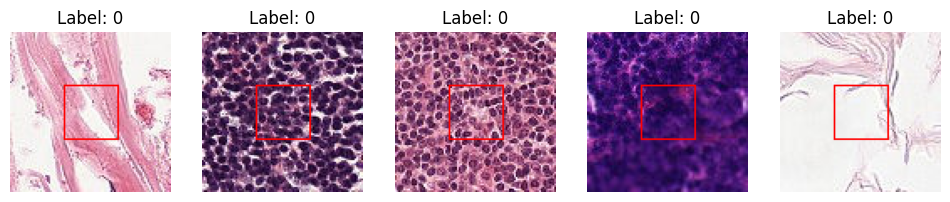

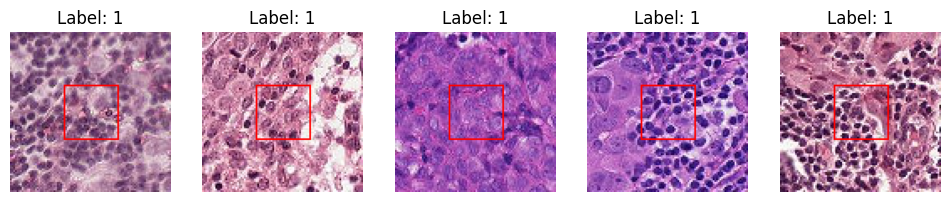

image size: (96, 96)
image mode: RGB


In [5]:
### show sample image files
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# add 'train_filepath' to dataframe
train_dir = Path("/kaggle/input/histopathologic-cancer-detection/train")
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels['train_filepath'] = train_labels['id'].apply(lambda x: str(train_dir / f'{x}.tif'))
# # convert 'label' field to string.
# train_labels['label'] = train_labels['label'].astype(str)

# show sample file
def show_samples(label, df=train_labels, num_images=5):
    subset = df[df['label'] == label].sample(num_images, random_state=42)
    plt.figure(figsize=(12, 4))
    for i, row in enumerate(subset.itertuples()):
        img = cv2.imread(row.train_filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        center = (32, 32, 64, 64)  
        cv2.rectangle(img, (center[0], center[1]), (center[2], center[3]), (255, 0, 0), 1)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Label: {row.label}')
        plt.axis('off')
    plt.show()


show_samples(0)  # Non-cancerous
show_samples(1)  # Cancerous

# check image size and channel
img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{train_labels['id'].iloc[0]}.tif"
img = Image.open(img_path)
print(f"image size: {img.size}") 
print(f"image mode: {img.mode}") 

In [12]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Pre-process the data ###

- Preprocess and split the data 80/20 into training and validation dataset
- Prepare load_image method to be used
- Prepare tensor pipeline to load image, label pair in mini-batch of 64

In [13]:
from sklearn.model_selection import train_test_split
import cv2


# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=42
)

def load_image(path, label):
    def _load_image_py(path_tensor):
        path_str = path_tensor.numpy()
        if isinstance(path_str, bytes):
            path_str = path_str.decode("utf-8")
        img = cv2.imread(path_str)
        if img is None:
            raise ValueError(f"Failed to load image at path: {path_str}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img.astype(np.uint8)

    image = tf.py_function(func=_load_image_py, inp=[path], Tout=tf.uint8)
    image.set_shape([96, 96, 3])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)  
    return image, label

# Create training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['train_filepath'], train_df['label']))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['train_filepath'], val_df['label']))
validation_dataset = validation_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

print("Data Pre-processing complete..")

Data Pre-processing complete..


## III. Model Architecture ##

### Model Description ###

- This model implements traditional CNN model with three layers architecture.
- Model begins with 32 filters, and then this hyperparameter value doubled of each subsequent layer: 32, 64, 128 
- Since each image size is 96 x 96 pixel of RGB channel, input shape = (96,96, 3)
- To avoid overfitting, each convolution block is matched with pooling layer and batch-normalization.
- First layer use 5x5 kernel to learn major feature and then 3x3 kernel following inspiration of VGG-16. 

#### Reference ###
- Ref: https://www.geeksforgeeks.org/computer-vision/vgg-16-cnn-model
- Ref: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

<img src="https://developers.google.com/static/machine-learning/practica/image-classification/images/cnn_architecture.svg" width="600">

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

#input shape = 96x 96x 3 (width x height x RGB)
cnn_model = Sequential([
    # First CNN block 
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Second CNN block
    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Third CNN block
    Conv2D(128, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Output layer
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
cnn_model.summary()
three_layer_history = cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 96, 96, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,814,785 (18.37 MB)

 Trainable params: 4,814,337 (18.37 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 251s 89ms/step - accuracy: 0.8030 - auroc: 0.8634 - loss: 0.5798 - val_accuracy: 0.8649 - val_auroc: 0.9364 - val_loss: 0.3226
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 254s 92ms/step - accuracy: 0.8562 - auroc: 0.9249 - loss: 0.3476 - val_accuracy: 0.6053 - val_auroc: 0.6330 - val_loss: 2.0213
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 249s 90ms/step - accuracy: 0.8778 - auroc: 0.9425 - loss: 0.3053 - val_accuracy: 0.8142 - val_auroc: 0.9053 - val_loss: 0.4403
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 244s 89ms/step - accuracy: 0.8958 - auroc: 0.9561 - loss: 0.2663 - val_accuracy: 0.7590 - val_auroc: 0.7879 - val_loss: 1.2357
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 239s 87ms/step - accuracy: 0.9097 - auroc: 0.9648 - loss: 0.2367 - val_accuracy: 0.6999 - val_auroc: 0.7702 - val_loss: 1.7848
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 242s 88ms/step - accuracy: 0.9187 - auroc: 0.9707 - loss: 0.2143 - val_accuracy: 0.8699 - val_auroc: 0.9441 - val


Training Metrics:
---------------------------
Loss: 0.1611
Accuracy: 0.9413
Auroc: 0.9829

Validation Metrics:
---------------------------
Validation loss: 0.2821
Validation accuracy: 0.8765
Validation auroc: 0.9567


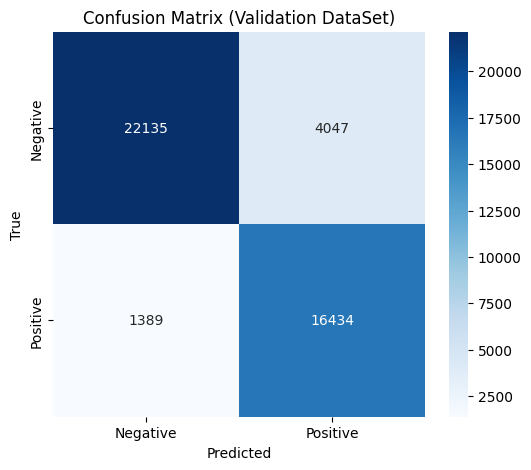


Confusion Matrix Metrics:
True Negatives (TN): 22135
False Positives (FP): 4047
False Negatives (FN): 1389
True Positives (TP): 16434


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

print("\nTraining Metrics:")
print("---------------------------")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {three_layer_history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
print("---------------------------")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {three_layer_history.history[metric][-1]:.4f}")



# show confusion matrix
y_true = []
y_pred = []
for images, labels in validation_dataset:
    preds = cnn_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix (Validation DataSet)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nConfusion Matrix Metrics:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

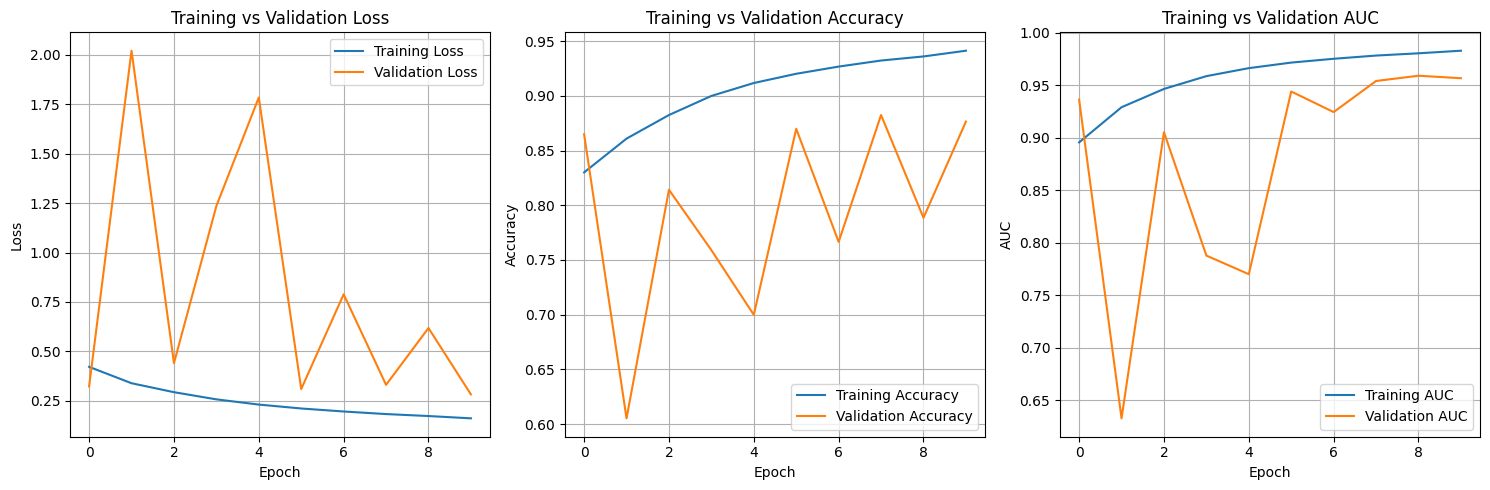

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(three_layer_history.history['loss'], label='Training Loss')
plt.plot(three_layer_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(three_layer_history.history['accuracy'], label='Training Accuracy')
plt.plot(three_layer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(three_layer_history.history['auroc'], label='Training AUC')
plt.plot(three_layer_history.history['val_auroc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## IV. Result Analysis Before Tuning ##

- Overall, this CNN model performs moderately for the histopathologic cancer detection task before tuning, as it has a simple architecture and achieves 87% accuracy on the validation dataset. 

### Details ###
- At the end, this simplistic CNN model achieves 94% accuracy in the training dataset, but drops accuracy to 87% in the validation set. The drop in accuracy suggested that the model might have overfit the training dataset.
- The curve of training loss starts at 0.4 and decreases steadily to 0.1 around epoch 8. However, validation loss spikes sharply, and this suggest the model is memorizing the training data rather than generalizing it.
- The accuracy curve follows similiar patterns as in the curve of the training loss. Even though there are spikes with the validation curve, the validation accuracy improved gradually.
- Spikes are also observed in the AUC curve, but it did achieve the highest value of 0.97, suggesting the model is highly effective despite fluctuations.


## V. Different Model Architectures ##

My approach to experimenting with different Convolutional Neural Network (CNN) architectures is as follows:

- Compare CNN model performance of same structure with higher and lower convolution layers
  - **2 convolutional layers**
  - **3 convolutional layers**
  - **5 convolutional layers**


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

#Two convolutional block architecture
two_layer_cnn_model = Sequential([
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    # Output layer
    Flatten(),Dropout(0.5),
    Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
])

two_layer_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
two_layer_history = two_layer_cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

print("\nTraining Metrics:")
print("---------------------------")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {two_layer_history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
print("---------------------------")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {two_layer_history.history[metric][-1]:.4f}")


Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 246s 87ms/step - accuracy: 0.7506 - auroc: 0.8130 - loss: 0.9512 - val_accuracy: 0.6956 - val_auroc: 0.8054 - val_loss: 0.7833
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 236s 86ms/step - accuracy: 0.7970 - auroc: 0.8718 - loss: 0.4374 - val_accuracy: 0.5930 - val_auroc: 0.4895 - val_loss: 1.1985
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 236s 86ms/step - accuracy: 0.8000 - auroc: 0.8792 - loss: 0.4242 - val_accuracy: 0.7654 - val_auroc: 0.8579 - val_loss: 0.5426
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 236s 86ms/step - accuracy: 0.8069 - auroc: 0.8862 - loss: 0.4121 - val_accuracy: 0.6590 - val_auroc: 0.7484 - val_loss: 0.9752
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 238s 86ms/step - accuracy: 0.8129 - auroc: 0.8922 - loss: 0.4006 - val_accuracy: 0.7250 - val_auroc: 0.8227 - val_loss: 0.7180
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 239s 87ms/step - accuracy: 0.8158 - auroc: 0.8982 - loss: 0.3887 - val_accuracy: 0.7234 - val_auroc: 0.8563 - val

In [14]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

#input shape = 96x 96x 3 (width x height x RGB)
five_layer_cnn_model = Sequential([
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(128, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(256, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(512, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
        
    # Output layer
    Flatten(),Dropout(0.5),
    Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
])

five_layer_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
five_layer_history = five_layer_cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

print("\nTraining Metrics:")
print("---------------------------")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {five_layer_history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
print("---------------------------")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {five_layer_history.history[metric][-1]:.4f}")


Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 471s 167ms/step - accuracy: 0.8264 - auroc: 0.8896 - loss: 0.4382 - val_accuracy: 0.8562 - val_auroc: 0.9263 - val_loss: 0.3609
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 255s 93ms/step - accuracy: 0.9018 - auroc: 0.9578 - loss: 0.2541 - val_accuracy: 0.8047 - val_auroc: 0.8299 - val_loss: 0.7497
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 277s 100ms/step - accuracy: 0.9230 - auroc: 0.9706 - loss: 0.2098 - val_accuracy: 0.8775 - val_auroc: 0.9546 - val_loss: 0.2998
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 267s 96ms/step - accuracy: 0.9349 - auroc: 0.9785 - loss: 0.1779 - val_accuracy: 0.8761 - val_auroc: 0.9407 - val_loss: 0.3136
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 252s 91ms/step - accuracy: 0.9452 - auroc: 0.9831 - loss: 0.1550 - val_accuracy: 0.7491 - val_auroc: 0.7743 - val_loss: 1.3463
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 255s 93ms/step - accuracy: 0.9500 - auroc: 0.9860 - loss: 0.1407 - val_accuracy: 0.8486 - val_auroc: 0.9209 - v

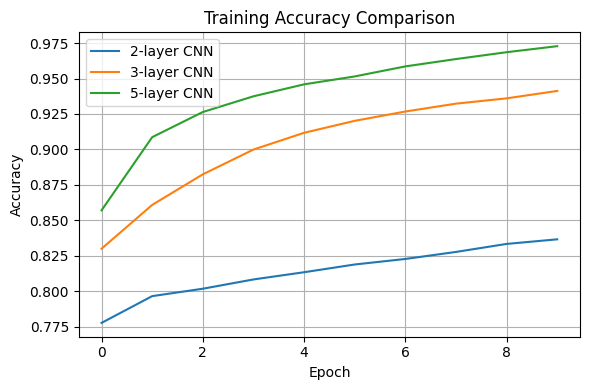

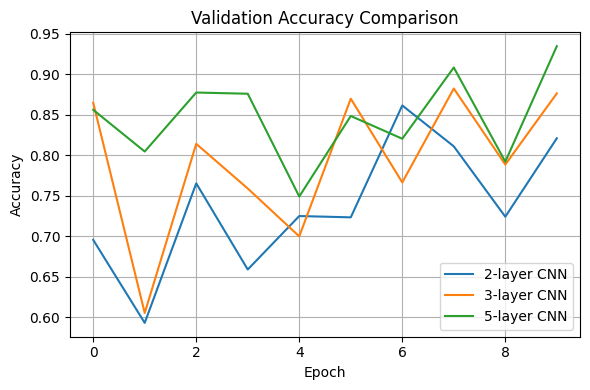

         Model  Max Training Accuracy  Max Validation Accuracy
0  2-layer CNN                 0.8367                   0.8616
1  3-layer CNN                 0.9413                   0.8825
2  5-layer CNN                 0.9728                   0.9348


In [35]:
import matplotlib.pyplot as plt

histories = {
    "2-layer CNN": two_layer_history,
    "3-layer CNN": three_layer_history,
    "5-layer CNN": five_layer_history
}

metrics = ['accuracy', 'val_accuracy']
titles = {
    'accuracy': 'Training Accuracy',
    'val_accuracy': 'Validation Accuracy'
}

for metric in ['accuracy', 'val_accuracy']:    
    plt.figure(figsize=(6, 4))
    for label, history in histories.items():
        plt.plot(history.history[metric], label=label)
    plt.title(f"{titles[metric]} Comparison")
    plt.xlabel("Epoch")
    plt.ylabel(metric.split('_')[-1].capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

records = []
for name, hist in histories.items():
    max_train_accuracy = max(hist.history['accuracy'])
    max_val_accuracy = max(hist.history['val_accuracy'])
    records.append({
        "Model": name,
        "Max Training Accuracy": round(max_train_accuracy, 4),
        "Max Validation Accuracy": round(max_val_accuracy, 4)
    })
metrics_df = pd.DataFrame(records)
print(metrics_df)

## VI. Performance Analysis with Different Model Architectures ##

- Deeper model achieve higher traing and validation accuracy
  - 5 layer CNN reach 97% training accuracy, compared to 94% (3 layers), and 84% (2 layers)
  - 5 layer CNN reach 93% training accuracy, compared to 88% (3 layers), and 86% (2 layers)
  - Deeper network have greater capacity to learn more complex pattern

- Deeper model may introduce higher risk of overfitting
  - 5 layer model have relatively deeper gap between training and validation accuracy.
  - Performance gap widens with depth, suggesting a higher risk of overfitting and early stopping is required (next performance tuning).

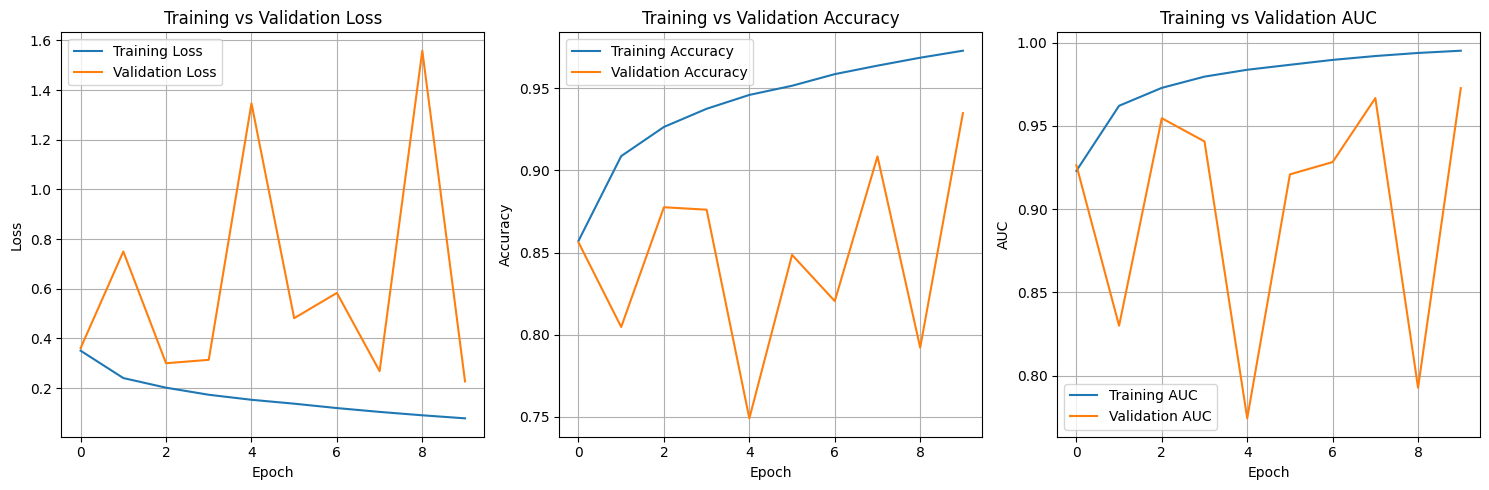

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(five_layer_history.history['loss'], label='Training Loss')
plt.plot(five_layer_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(five_layer_history.history['accuracy'], label='Training Accuracy')
plt.plot(five_layer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(five_layer_history.history['auroc'], label='Training AUC')
plt.plot(five_layer_history.history['val_auroc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## VII. Hyper-parameter Tuning by reducing Number of Filters ##

* **Validation accuracy lower than training accuracy** indicates **overfitting**, where the model performs well on training data but fails to generalize to unseen data.
* Overfitting may result from too many filters that learn noise patterns from the training data.
* Less number of filters encouraging to focus on essential patterns rather than memorizing training data.

- Three set number of filters be used for performance comparison:
  - (16, 32, 64) 
  - (24, 48, 96)
  - (32, 64, 128) (existing value)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC


filter_config = [(16, 32, 64, 128, 256), (24, 48, 96, 192, 384)]
# add previous model result
history_dict = {} 
history_dict[(32, 64, 128, 256, 512)] = five_layer_history
best_validation_accuracy = five_layer_history.history['val_accuracy'][-1]
best_filter_config = (32, 64, 128, 256, 512)
best_filter_history = five_layer_history

for idx, (f1, f2, f3, f4, f5) in enumerate(filter_config):
    filter_label = (f1, f2, f3, f4, f5)
    print(f"\nTraining Model with Filters: {filter_label}...")
    # best model architecture (5 layers)
    model_filter_tuning = Sequential([
        Conv2D(f1, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f2, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f3, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f4, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f5, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
            
        # Output layer
        Flatten(),Dropout(0.5),
        Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
    ])

        
    model_filter_tuning.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
    history_filter_tuning = model_filter_tuning.fit(train_dataset, validation_data=validation_dataset, epochs=10, verbose=1)
    history_dict[filter_label] = history_filter_tuning
    final_validation_accuracy =  history_filter_tuning.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy for {filter_label}: {final_validation_accuracy:.4f}")

    # Update best if current model is better
    if final_validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = final_validation_accuracy
        best_filter_config = filter_label
        best_filter_history = history_filter_tuning

print("Best Filter Configuration:")
print(f"Filters: {best_filter_config}")
print(f"Validation Accuracy: {best_validation_accuracy:.4f}")


Training Model with Filters: 16, 32, 64...
Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 249s 87ms/step - accuracy: 0.7946 - auroc: 0.8558 - loss: 0.5885 - val_accuracy: 0.8493 - val_auroc: 0.9333 - val_loss: 0.3401
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 234s 85ms/step - accuracy: 0.8537 - auroc: 0.9225 - loss: 0.3512 - val_accuracy: 0.8425 - val_auroc: 0.9188 - val_loss: 0.3744
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 242s 87ms/step - accuracy: 0.8669 - auroc: 0.9347 - loss: 0.3238 - val_accuracy: 0.8236 - val_auroc: 0.9236 - val_loss: 0.4353
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 238s 86ms/step - accuracy: 0.8799 - auroc: 0.9451 - loss: 0.2971 - val_accuracy: 0.8737 - val_auroc: 0.9464 - val_loss: 0.3003
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 250s 91ms/step - accuracy: 0.8933 - auroc: 0.9531 - loss: 0.2736 - val_accuracy: 0.8661 - val_auroc: 0.9483 - val_loss: 0.3623
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 236s 86ms/step - accuracy: 0.9036 - auroc: 0.9607 - loss: 0.2494 - va

### VI.2. Hyper-parameter Tuning by reducing learning rates and early stopping ###

* **Validation accuracy lower than training accuracy** indicates **overfitting**, where the model performs well on training data but fails to generalize to unseen data.
* Overfitting may result from too many filters that learn noise patterns from the training data.
* Less number of filters encouraging to focus on essential patterns rather than memorizing training data.

- Three set number of filters be used for performance comparison:
  - (16, 32, 64) 
  - (24, 48, 96)
  - (32, 64, 128) (existing value)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define learning rate configurations
learning_rates = [5e-4, 1e-3, 5e-3]
best_validation_auc = 0.0 
best_learning_rate = None
best_lr_history = None

for idx, lr in enumerate(learning_rates):
    print(f"\nTraining Model with Learning Rate: {lr}...")
    
    model_learning_rate = Sequential([
        Conv2D(24, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

        Conv2D(48, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

        Conv2D(96, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

        Flatten(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model with the current learning rate
    model_lr_tuning.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_auroc',  # Monitor AUC for better alignment with Kaggle metric
        patience=3,           # Stop if no improvement for 3 epochs
        mode='max',           # Maximize AUC
        restore_best_weights=True  # Restore weights with best validation AUC
    )
    
    # Train the model
    history = model_lr_tuning.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=20,  # Increased epochs to allow early stopping to find optimal point
        verbose=1,
        callbacks=[early_stopping]
    )
    
    # Get the final validation AUC (from the best epoch due to early stopping)
    final_validation_auc = max(history.history['val_auroc'])  # Use max to reflect best epoch
    print(f"Final Validation AUC for LR {lr}: {final_validation_auc:.4f}")

    # Update best if current model is better
    if final_validation_auc > best_validation_auc:
        best_validation_auc = final_validation_auc
        best_learning_rate = lr
        best_lr_history = history

# Print best results
print("\nBest Learning Rate Configuration:")
print(f"Learning Rate: {best_learning_rate}")
print(f"Validation AUC: {best_validation_auc:.4f}")

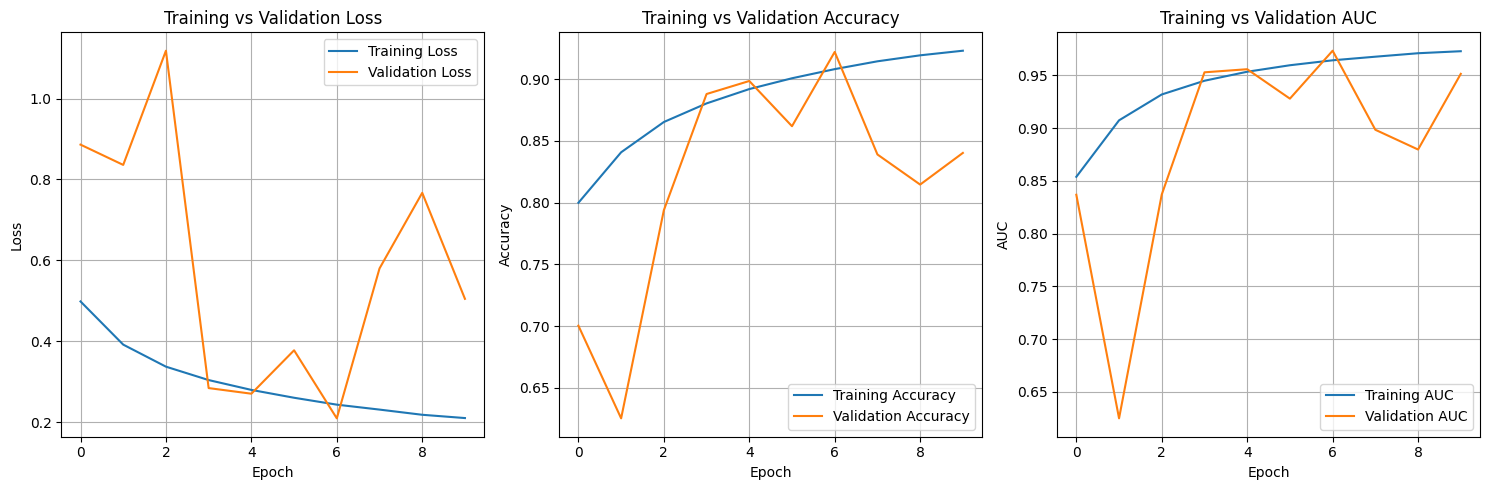

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(best_filter_history.history['loss'], label='Training Loss')
plt.plot(best_filter_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(best_filter_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_filter_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(best_filter_history.history['auroc'], label='Training AUC')
plt.plot(best_filter_history.history['val_auroc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## VIII. Conclusion ##

Results and Analysis (35 pts) 

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In [ ]:
https://www.youtube.com/watch?v=bemDFpNooA8&list=PLQY2H8rRoyvwWuPiWnuTDBHe7I0fMSsfO

In [ ]:
print("\nTraining Metrics:")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {history.history[metric][-1]:.4f}")

## VI. Future Works and Reference: ###

Ref: 
https://www.youtube.com/watch?v=bemDFpNooA8&list=PLQY2H8rRoyvwWuPiWnuTDBHe7I0fMSsfO
